# Réseau de neurone from scratch

## Définition des classes

- Tensor (Trop compliqué car backend numpy en cpp)
- Parameter
- Function (forward / backward)
- Linear
- Couche
- Adam
- Réseau

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Parameter:
    def __init__(self, data, requires_grad=True):
        self._requires_grad = requires_grad
        self._grad = None
        self.data = data

In [3]:
class Module:
    def __init__(self):
        self.modules = {}
        self.parameters = []
        self.fns = []

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
    def add_module(self, name, module):
        if not isinstance(module, Module):
            raise TypeError("module must be an instance of Module")
        self.modules.update({name: module})
        self.parameters.extend(module.get_parameters())

    def clear_fns(self):
        self.fns = []

    def register_parameter(self, parameter):
        self.parameters.append(parameter)

    def register_function(self, fn):
        self.fns.append(fn)

    def get_parameters(self):
        return self.parameters

In [4]:
class Function:
    def __init__(self):
        self._input = None
        self._output = None
        self._grad_input = None
        self._grad_output = None

    def forward(self, *args):
        raise NotImplementedError("forward method not implemented")
    def backward(self, *args):
        raise NotImplementedError("backward method not implemented")
    def __call__(self, *args):
        self._input = args
        self._output = self.forward(*args)
        return self._output

In [5]:
class Add(Function):
    def forward(self, x, y):
        assert x.shape[-1] == y.shape[-1], f"x and y must have the same shape but got {x.shape[-1]} and {y.shape[-1]}"
        return x + y

    def backward(self, grad_output):
        return grad_output, grad_output.sum(axis=0) / grad_output.shape[0]
    
class Mult(Function):
    def forward(self, x, y):
        assert x.shape[-1] == y.shape[-2], f"impossible to compute matmult due to wrong shape (got {x.shape} and {y.shape})"
        self._input = (x, y)
        output = x @ y
        return output
    
    def backward(self, grad_output):
        x, y = self._input
        # grad_output (batch_size, out_features)
        # x (batch_size, in_features)
        # y (in_features, out_features)
        grad_y = x.T @ grad_output / x.shape[0]
        grad_x = grad_output @ y.T
        return grad_x, grad_y
    
class ReLU(Function):
    def __init__(self, eps=0):
        self.eps = eps

    def forward(self, x):
        self._input = x
        return np.maximum(self.eps * x, x)

    def backward(self, grad_output):
        x = self._input
        grad_input = np.where(x > 0, grad_output, self.eps * grad_output)
        return grad_input
    
class Identity(Function):
    def forward(self, x):
        self._input = x
        return x

    def backward(self, grad_output):
        return grad_output    

class Arctan(Function):
    def forward(self, x):
        self._input = x
        return np.arctan(x)

    def backward(self, grad_output):
        x = self._input
        grad_input = grad_output / (1 + x**2)
        return grad_input
    
class Tanh(Function):
    def forward(self, x):
        self._input = x
        return np.tanh(x)

    def backward(self, grad_output):
        x = self._input
        grad_input = grad_output * (1 - np.tanh(x)**2)
        return grad_input
    
class MSELoss(Function):
    def forward(self, y_pred, y_true):
        self._input = (y_pred, y_true)
        return np.mean((y_pred - y_true) ** 2)

    def backward(self, grad_output=1.0):
        y_pred, y_true = self._input
        grad_input = (2 * (y_pred - y_true))
        return grad_input 

In [6]:
class Linear(Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(np.random.normal(0, 0.02, size=(in_features, out_features)))
        self.register_parameter(self.weight)
        if bias:
            self.bias = Parameter(np.random.normal(0, 0.02, size=(out_features)))
            self.register_parameter(self.bias)
        else:
            self.bias = None
    
    def forward(self, x):
        # x: (batch_size, in_features)
        # weight: (in_features, out_features)
        # bias: (out_features,)
        # output: (batch_size, out_features)
        if self.bias is not None:
            m = Mult()
            self.register_function(m)
            a = Add()
            self.register_function(a)
            res = m(x, self.weight.data)
            res = a(res, self.bias.data)
            return res
        else:
            m = Mult()
            self.register_function(m)
            res = m(x, self.weight.data)
            return res
        
    def backward(self, grad_output):
        if self.bias is not None:
            dx, db = self.fns[-1].backward(grad_output)
            dx, dw = self.fns[-2].backward(dx)
            self.weight._grad = dw
            self.bias._grad = db
            self.clear_fns()
            return dx
        else:
            dx, dw = self.fns[-1].backward(grad_output)
            self.weight._grad = dw
            self.clear_fns()
            return dx
        

In [7]:
class Layer(Module):
    def __init__(self, in_features, out_features, activation=None):
        super().__init__()
        self.linear = Linear(in_features, out_features)
        self.activation = ReLU() if activation is None else activation
        self.add_module('linear', self.linear)

    def forward(self, x):
        x = self.linear.forward(x)
        if self.activation is not None:
            x = self.activation(x)
        return x
    
    def backward(self, grad_output):
        if self.activation is not None:
            grad_output = self.activation.backward(grad_output)
        dx = self.linear.backward(grad_output)
        return dx

In [8]:
class Adam:
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.params = params
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = [np.zeros_like(p) for p in params]
        self.v = [np.zeros_like(p) for p in params]
        self.t = 0

    def step(self):
        self.t += 1
        if len(self.params) == 0:
            raise ValueError("No parameters to optimize")
        for i, p in enumerate(self.params):
            if p._requires_grad:
                if (p._grad == .0).all():
                    print("Gradient is zero")
                grad = p._grad
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)
                m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                update = self.lr * m_hat / (np.sqrt(v_hat) + self.eps)
                assert p.data.shape == update.shape, f"Shape mismatch: {p.data.shape} vs {update.shape}"
                p.data = p.data - update
                p._grad = None

In [9]:
class NeuralNetwork(Module):
    def __init__(self, nb_layers=4, in_features=1, out_features=1, hidden_features=16, activation=Arctan()):
        super().__init__()
        self.layers = []
        self.loss = MSELoss()
        self.register_function(self.loss)
        self.layers.append(Layer(in_features, hidden_features, activation))
        for _ in range(nb_layers):
            layer = Layer(hidden_features, hidden_features, activation)
            self.layers.append(layer)
        self.layers.append(Linear(hidden_features, out_features))
        for i, layer in enumerate(self.layers):
            self.add_module(f'layer_{i}', layer)

    def forward(self, x, y=None):
        for layer in self.layers:
            x = layer.forward(x)
        if y is not None:
            loss = self.loss(x, y)
            return x, loss
        return x, None

    def __call__(self, *args, **kwds):
        return super().__call__(*args, **kwds)
    
    def backward(self):
        grad_output = self.loss.backward()
        for i, layer in enumerate(reversed(self.layers)):
            grad_output = layer.backward(grad_output)
        return grad_output

In [10]:
nn = NeuralNetwork(nb_layers=0, in_features=2, out_features=1, hidden_features=2)
layer0 = nn.layers[0]
layer0.linear.weight.data = np.array([[1,2], [3,4]])
layer0.linear.bias.data = np.array([1, 2])
linear0 = layer0.linear
layer1 = nn.layers[1]
layer1.weight.data = np.array([[1], [2]])
layer1.bias.data = np.array([-1])
x = np.array([[2, 3], [3, 4], [4, 5]])
y_hat = np.array([[3], [4], [5]])
lin_adam = Adam(nn.get_parameters(), lr=0.01)
y, l = nn(x, y_hat)
print(f"Input: {x}")
print(f"Weight 0: {linear0.weight.data}")
print(f"Bias 0: {linear0.bias.data}")
print(f"Weight 1: {layer1.weight.data}")
print(f"Bias 1: {layer1.bias.data}")
print(f"Output: {y}")
print(f"Target: {y_hat}")
dx = nn.backward()
print(f"Loss: {l}")
print(f"dx: {dx}")
print(f"Weight 0 grad: {linear0.weight._grad}")
print(f"Bias 0 grad: {linear0.bias._grad}")
print(f"Weight 1 grad: {layer1.weight._grad}")
print(f"Bias 1 grad: {layer1.bias._grad}")

lin_adam.step()
print(f"Updated 0 Weight: {linear0.weight.data}")
print(f"Updated 0 Bias: {linear0.bias.data}")
print(f"Updated 1 Weight: {layer1.weight.data}")
print(f"Updated 1 Bias: {layer1.bias.data}")

Input: [[2 3]
 [3 4]
 [4 5]]
Weight 0: [[1 2]
 [3 4]]
Bias 0: [1 2]
Weight 1: [[1]
 [2]]
Bias 1: [-1]
Output: [[3.51825074]
 [3.56668501]
 [3.59578859]]
Target: [[3]
 [4]
 [5]]
Loss: 0.809385127304723
dx: [[ 0.01990523  0.04695874]
 [-0.00937993 -0.02213197]
 [-0.01947157 -0.0459467 ]]
Weight 0 grad: [[-0.00794464 -0.00706362]
 [-0.00902043 -0.00801677]]
Bias 0 grad: [-0.00107579 -0.00095315]
Weight 1 grad: [[-1.34546814]
 [-1.35749428]]
Bias 1 grad: [-0.8795171]
Updated 0 Weight: [[1.00999999 2.00999999]
 [3.00999999 4.00999999]]
Updated 0 Bias: [1.00999991 2.0099999 ]
Updated 1 Weight: [[1.01]
 [2.01]]
Updated 1 Bias: [-0.99]


In [11]:
for i in range(1000):
    y, l = nn(x, y_hat)
    dx = nn.backward()
    print(f"Loss: {l}")
    lin_adam.step()
nn(x)

Loss: 0.7748949895871119
Loss: 0.7438655815003553
Loss: 0.7163406547748082
Loss: 0.6923340838758087
Loss: 0.6718220035315948
Loss: 0.6547360446443374
Loss: 0.6409587578159335
Loss: 0.6303183238717571
Loss: 0.6225828871996507
Loss: 0.6174582557200434
Loss: 0.614591417256209
Loss: 0.6135809428108129
Loss: 0.6139942300135468
Loss: 0.6153902433449092
Loss: 0.6173451835719268
Loss: 0.6194776713291353
Loss: 0.6214698551580297
Loss: 0.6230815554124013
Loss: 0.6241559858902463
Loss: 0.6246172545944226
Loss: 0.6244611787545358
Loss: 0.6237416426345971
Loss: 0.6225547840287179
Loss: 0.6210229281316179
Loss: 0.6192796509634556
Loss: 0.61745683884546
Loss: 0.6156742092711205
Loss: 0.6140314880038323
Loss: 0.6126032698412263
Loss: 0.6114364839512819
Loss: 0.6105503002220135
Loss: 0.6099382247966144
Loss: 0.609572031597543
Loss: 0.6094070691729011
Loss: 0.6093883880897217
Loss: 0.6094570782570242
Loss: 0.6095562094429483
Loss: 0.6096358417196264
Loss: 0.609656709490859
Loss: 0.6095923621118239
Loss:

(array([[2.99998549],
        [4.00002992],
        [4.99997827]]),
 None)

In [12]:
class Dataset:
    def __init__(self, min_max_value, nb_data=1000, eval_ratio=0.1, batch_size=32):
        self.min_max_value = min_max_value
        self.nb_data = nb_data
        self.eval_ratio = eval_ratio
        self.batch_size = batch_size
        x_ = np.random.uniform(-min_max_value, min_max_value, size=(nb_data, batch_size, 1))
        y_ = np.sin(x_)
        self.nb_eval = int(nb_data * eval_ratio)
        self.x_train = x_[:-self.nb_eval, :, :]
        self.y_train = y_[:-self.nb_eval, :, :]
        self.x_eval = x_[-self.nb_eval:, :, :]
        self.y_eval = y_[-self.nb_eval:, :, :]

    def get_train_data(self):
        return self.x_train, self.y_train
    
    def get_eval_data(self):
        return self.x_eval, self.y_eval
    
    def eval_len(self):
        return self.x_eval.shape[0]
    
    def train_len(self):
        return self.x_train.shape[0]

In [ ]:
class LR_Scheduler:
    def __init__(self, optimizer, start_value=0.1, end_value=0.01, nb_steps=1000):
        self.optimizer = optimizer
        self.start_value = start_value
        self.end_value = end_value
        self.nb_steps = nb_steps
        self.current_step = 0

    def step(self):
        if self.current_step < self.nb_steps:
            lr = self.start_value * np.exp(-5 * self.current_step / self.nb_steps)
            self.optimizer.lr = lr
            self.current_step += 1
        else:
            self.optimizer.lr = self.end_value

In [38]:
model = NeuralNetwork(nb_layers=2, in_features=1, out_features=1, hidden_features=128, activation=Tanh())
adam = Adam(model.get_parameters(), lr=0.02)
nb_data = int(5*1e3)

In [39]:
min_max_value = 10 
batch_size = 64
nb_epochs = 10

dataset = Dataset(min_max_value, nb_data=nb_data, eval_ratio=0.1, batch_size=batch_size)

scheduler = LR_Scheduler(adam, start_value=0.02, end_value=1e-7, nb_steps=dataset.train_len() * nb_epochs)

In [40]:
logging_loss = 0
logging_step = 2000


def normalize(x):
    return x / min_max_value

def evaluate(model,):
    eval_log_loss = 0
    for x, y in zip(*dataset.get_eval_data()):
        x = normalize(x)
        loss = model(x, y)[1]
        eval_log_loss += loss
    print(f"Evaluation: {eval_log_loss.item()/ dataset.eval_len()}")
    
for epoch in range(nb_epochs):
    for idx, (x, y) in enumerate(zip(*dataset.get_train_data())):
        x = normalize(x)
        loss = model(x, y)[1]
        model.backward()
        adam.step()
        scheduler.step()
        logging_loss = loss.item()
        if idx % logging_step == 0:
            print(f"{logging_loss/logging_step:.3e} with the lr={adam.lr:.3e} at step {idx} in epoch {epoch}")
            logging_loss = 0
    evaluate(model)

2.610e-04 with the lr=2.000e-02 at step 0 in epoch 0
1.245e-04 with the lr=1.750e-02 at step 2000 in epoch 0
3.223e-05 with the lr=1.532e-02 at step 4000 in epoch 0
Evaluation: 0.05306154775536759
2.507e-05 with the lr=1.482e-02 at step 0 in epoch 1
1.002e-05 with the lr=1.297e-02 at step 2000 in epoch 1
5.210e-06 with the lr=1.135e-02 at step 4000 in epoch 1
Evaluation: 0.01627924094042509
8.256e-06 with the lr=1.098e-02 at step 0 in epoch 2
3.254e-06 with the lr=9.606e-03 at step 2000 in epoch 2
4.198e-06 with the lr=8.407e-03 at step 4000 in epoch 2
Evaluation: 0.0059982001897673455
3.237e-06 with the lr=8.131e-03 at step 0 in epoch 3
2.764e-06 with the lr=7.116e-03 at step 2000 in epoch 3
9.176e-07 with the lr=6.228e-03 at step 4000 in epoch 3
Evaluation: 0.002229782200587432
6.331e-07 with the lr=6.024e-03 at step 0 in epoch 4
4.399e-06 with the lr=5.272e-03 at step 2000 in epoch 4
2.055e-06 with the lr=4.614e-03 at step 4000 in epoch 4
Evaluation: 0.0015672805335623648
7.733e-07 

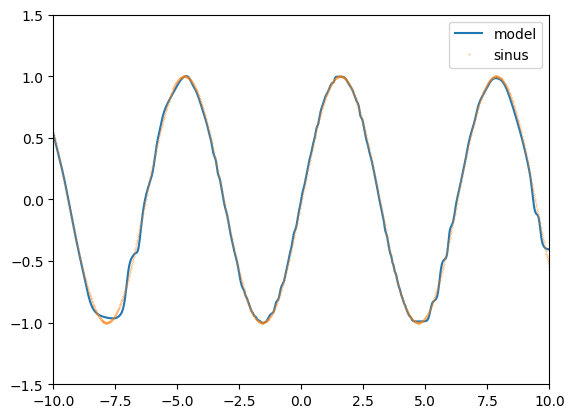

In [41]:
x = np.linspace(-10, 10, 1000)
x = x.reshape(-1, 1)
x_ = normalize(x)
y_model = model(x_)[0]
plt.plot(x, y_model, label="model")
plt.plot(x, np.sin(x), '.', label="sinus", markersize=0.5)
plt.xlim(-10,10)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.show()